In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from skimage.metrics import structural_similarity as compare_ssim
from facenet_pytorch.models.mtcnn import MTCNN
mtcnn_detector = MTCNN(margin=0, thresholds=[0.65, 0.75, 0.75], device="cpu")

from face_cutout import sensory_cutout, remove_eyes, remove_mouth, remove_nose, convex_hull_cutout

If landmarks aren't supplied to sensory_cutout() it will determine them automatically using either supplied original image or fake image. Using original image for landmark detection is preferred for best output. If mask is not given then threshold checking isn't applied. Cutout is applied without any threshold.

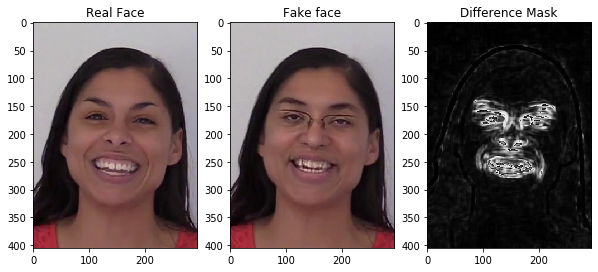

In [5]:
# Load original and fake image
fake = cv2.imread('test_samples/sample_faces/fake_0.png')
fake = cv2.cvtColor(fake, cv2.COLOR_BGR2RGB)
original = cv2.imread("test_samples/sample_faces/ori_0.png")
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

# Detect landmarks from original image using MTCNN
frame_img = Image.fromarray(original)
batch_boxes, conf, landmarks = mtcnn_detector.detect(frame_img, landmarks=True)
if landmarks is not None:
    landmarks = np.around(landmarks[0]).astype(np.int16)

mtcnn_vis = original.copy()
for x,y in landmarks:
    mtcnn_vis = cv2.circle(mtcnn_vis, (x,y), radius=5, color=(0, 0, 255), thickness=2)

plt.figure()
plt.imshow(mtcnn_vis)
plt.show()

# Compute difference using SSIM
d, a = compare_ssim(original, fake, multichannel=True, full=True)
a = 1 - a
diff = (a * 255).astype(np.uint8)
diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

# Plot
fig = plt.figure(figsize=(10,20))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(original)
ax1.title.set_text('Real Face')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(fake)
ax2.title.set_text('Fake face')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(diff,cmap='gray')
ax3.title.set_text('Difference Mask')

plt.show()

remove_eyes(), remove_mouth(), remove_nose() need to be supplied with landmarks. They are called internally by sensory_cutout()

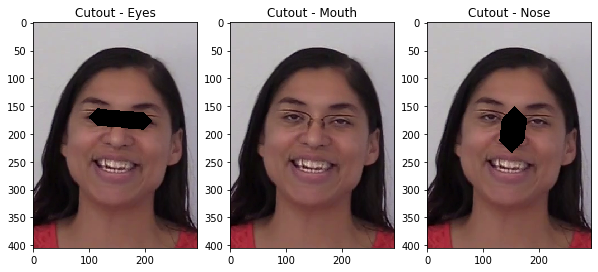

In [6]:
eyes = remove_eyes(fake, landmarks=landmarks, mask=diff, cutout_fill=0)
mouth = remove_mouth(fake, landmarks=landmarks, mask=diff, cutout_fill=0)
nose = remove_nose(fake, landmarks=landmarks, mask=diff, cutout_fill=0)

# Plot
fig = plt.figure(figsize=(10,20))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(eyes)
ax1.title.set_text('Cutout - Eyes')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(mouth)
ax2.title.set_text('Cutout - Mouth')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(nose)
ax3.title.set_text('Cutout - Nose')

plt.show()


In above figure mouth didn't augment because of fake artifacts. The entire mouth is fake. It didn't cutout because of threshold

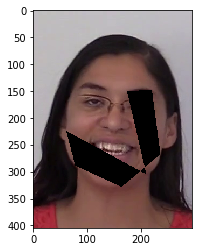

In [14]:
convex_hull = convex_hull_cutout(fake, original=original, mask=diff, probability=1.0)

plt.imshow(convex_hull)
plt.show()